In [1]:
import torch
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

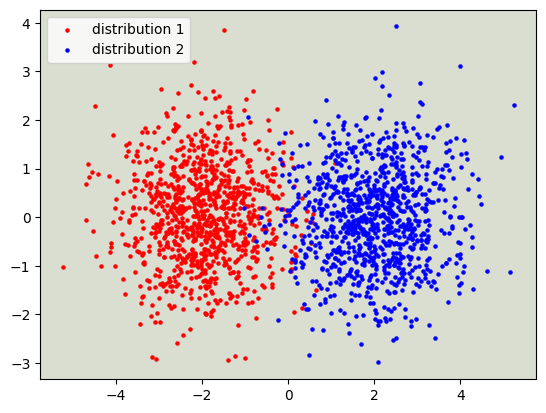

In [2]:
np.random.seed(seed=42)

mean_1 = np.array([-2, 0])
cov_1 = np.identity(2)

mean_2 = np.array([2, 0])
cov_2 = np.identity(2)

n_samples = 1000
samples_1 = np.random.multivariate_normal(mean_1, cov_1, n_samples)
samples_2 = np.random.multivariate_normal(mean_2, cov_2, n_samples)
samples = np.concatenate([samples_1, samples_2], axis=0)

fig, ax = plt.subplots(1, 1)
ax.scatter(*zip(*samples_1), s=5, color="red", label="distribution 1")
ax.scatter(*zip(*samples_2), s=5, color="blue", label="distribution 2")
ax.autoscale(enable=True)
ax.set_facecolor((0.85, 0.87, 0.82))
ax.legend(loc='best')

In [3]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable


def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE_H(nn.Module):

    def __init__(self, x_dim=2, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.x_dim = x_dim
        self.h_dim_1 = 256
        self.h_dim_2 = 256
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Linear(self.x_dim, self.h_dim_1, bias=True),
            nn.ReLU(True),
            nn.Linear(self.h_dim_1, self.h_dim_2, bias=True),
            nn.ReLU(True),
            nn.Linear(self.h_dim_2, self.z_dim * 2, bias=True),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.z_dim, self.h_dim_2),
            nn.ReLU(True),
            nn.Linear(self.h_dim_2, self.h_dim_1, bias=True),
            nn.ReLU(True),
            nn.Linear(self.h_dim_1, self.x_dim, bias=True),
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)
        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)

def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [4]:
class Dataset2D(torch.utils.data.Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return torch.from_numpy(self.samples[idx])

In [5]:
def reconstruction_loss(x, x_recon, distribution):
    batch_size = x.size(0)
    assert batch_size != 0

    if distribution == 'bernoulli':
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, size_average=False).div(batch_size)
    elif distribution == 'gaussian':
        x_recon = F.sigmoid(x_recon)
        recon_loss = F.mse_loss(x_recon, x, size_average=False).div(batch_size)
    else:
        recon_loss = None

    return recon_loss


def kl_divergence(mu, logvar):
    batch_size = mu.size(0)
    assert batch_size != 0
    if mu.data.ndimension() == 4:
        mu = mu.view(mu.size(0), mu.size(1))
    if logvar.data.ndimension() == 4:
        logvar = logvar.view(logvar.size(0), logvar.size(1))

    klds = -0.5*(1 + logvar - mu.pow(2) - logvar.exp())
    total_kld = klds.sum(1).mean(0, True)
    dimension_wise_kld = klds.mean(0)
    mean_kld = klds.mean(1).mean(0, True)

    return total_kld, dimension_wise_kld, mean_kld

In [13]:
objective = "H"
num_epochs = 10000
model = BetaVAE_H(x_dim=2, z_dim=2)
lr = 0.00001
beta_1 = 0.9
beta_2 = 0.999
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta_1, beta_2))
model = model.double()

dataset = Dataset2D(samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2048)


for epoch_id in range(1, num_epochs + 1, 1):
    for batch_index, x in enumerate(dataloader):
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x.double())
        recon_loss = reconstruction_loss(x, x_recon, "gaussian")
        total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
        beta = 4

        if objective == 'H':
            beta_vae_loss = recon_loss + beta * total_kld
        elif objective == 'B':
            C = torch.clamp(self.C_max/self.C_stop_iter*self.global_iter, 0, self.C_max.data[0])
            beta_vae_loss = recon_loss + self.gamma*(total_kld-C).abs()

        beta_vae_loss.backward()
        optimizer.step()
        if batch_index % 500 == 0 and epoch_id % 5 == 0:
            print(f"epoch_id: {beta_vae_loss.item()}")
            

latent_codes = model._encode(torch.from_numpy(samples).double())
latent_codes.shape

/var/folders/k0/6v4q29qd1fn_5fdfpk3rw2sh0000gn/T/ipykernel_60931/984648499.py:69: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


epoch_id: 161.60422347735815
epoch_id: 135.47398621945823
epoch_id: 114.88862926884083
epoch_id: 98.79293336480279
epoch_id: 86.13968113478741
epoch_id: 76.1393213092916
epoch_id: 68.13675037034932
epoch_id: 61.63973583055461
epoch_id: 56.292630672510455
epoch_id: 51.82720140391166
epoch_id: 48.05172497631796
epoch_id: 44.790572261929285
epoch_id: 41.99454454096613
epoch_id: 39.54682355933079
epoch_id: 37.31994362044392
epoch_id: 35.36488349290739
epoch_id: 33.57825532357057
epoch_id: 31.993933713814286
epoch_id: 30.56355015365251
epoch_id: 29.220576813991503
epoch_id: 27.998362235504736
epoch_id: 26.89739465472688
epoch_id: 25.853513777295184
epoch_id: 24.888167242305364
epoch_id: 24.027910752738684
epoch_id: 23.1892676571376
epoch_id: 22.43358916763645
epoch_id: 21.714321717750387
epoch_id: 21.06893244155478
epoch_id: 20.420563856185236
epoch_id: 19.795549992595028
epoch_id: 19.253033618709043
epoch_id: 18.692228837765033
epoch_id: 18.2065649374347
epoch_id: 17.715685890179767
epoch_

KeyboardInterrupt: 

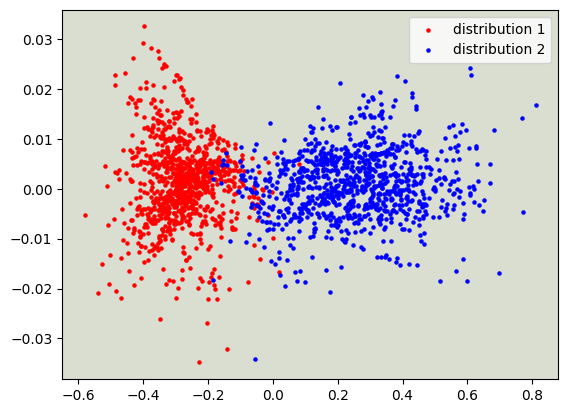

In [14]:
latent_codes_1 = model._encode(torch.from_numpy(samples_1).double())[:, :2].detach().numpy()
latent_codes_2 = model._encode(torch.from_numpy(samples_2).double())[:, :2].detach().numpy()

fig, ax = plt.subplots(1, 1)
ax.scatter(*zip(*latent_codes_1), s=5, color="red", label="distribution 1")
ax.scatter(*zip(*latent_codes_2), s=5, color="blue", label="distribution 2")
ax.autoscale(enable=True)
ax.set_facecolor((0.85, 0.87, 0.82))
ax.legend(loc='best')